 [시계열 전처리 1: 구조 변경 (Resampling)]에 대한 상세 수업 자료와 실습 노트북이다.

이 시간의 핵심은 "데이터의 시간 간격(Frequency)을 내 마음대로 조절하는 능력"을 기르는 것이다. 헬스케어 데이터는 1초 단위(심전도)부터 1개월 단위(정기검진)까지 간격이 제각각이므로, 분석을 위해서는 이를 통일하는 과정이 필수적이다.

---

# 📘시계열 구조 변경 (Resampling)

## 1. 리샘플링(Resampling)이란?
*   정의: 시계열 데이터의 시간 간격(주기, Frequency)을 변경하는 작업이다.
*   비유:
    *   Down-sampling (축소): 고화질 동영상을 저화질로 압축하거나, 줌-아웃(Zoom-out)하여 전체적인 흐름을 보는 것과 같다. 데이터의 양은 줄어들고 요약된다.
    *   Up-sampling (확대): 저화질 동영상의 프레임 사이를 채워 넣어 부드럽게 만들거나, 줌-인(Zoom-in)하는 것과 같다. 데이터의 양은 늘어나고 빈칸이 생긴다.

## 2. 왜 헬스케어에서 리샘플링이 필요한가?
의료 데이터는 소스(Source)마다 생성 주기가 다르다. 이를 통합 분석하기 위해서는 '공통된 시간 기준'을 맞춰야 한다.

1.  노이즈 제거 (Smoothing):
    *   웨어러블 기기의 심박수는 1초마다 뛴다. 이 데이터는 너무 들쑥날쑥하다(Noise).
    *   이를 '10분 평균'이나 '1시간 평균'으로 바꾸면(Down-sampling), 순간적인 튐 현상은 사라지고 환자의 '진짜 상태 추세(Trend)'가 보인다.
2.  데이터 통합 (Integration):
    *   *데이터 A:* 1분 간격의 혈압 데이터
    *   *데이터 B:* 1시간 간격의 투약 데이터
    *   이 둘을 같이 분석하려면, 혈압 데이터를 1시간 평균으로 줄이거나(Down), 투약 데이터를 1분 단위로 늘려야(Up) 한다. 보통은 전자를 택한다.

## 3. 리샘플링의 두 가지 방향

### 3.1. 다운 샘플링 (Down-sampling): 요약하기
데이터의 빈도를 낮춘다. (예: `초` 단위 $\rightarrow$ `분` 단위)
이때, 줄어든 구간을 어떤 값으로 대표할 것인가(Aggregation)가 중요하다.
*   평균(Mean): 혈압, 체온, 심박수 등 상태 정보에 사용한다.
*   합계(Sum): 운동량(걸음 수), 수액 투여량, 식사량 등 누적되는 양에 사용한다.
*   최대/최소(Max/Min): 위급 상황 모니터링 시 사용한다. (예: 지난 1시간 동안 혈당이 가장 높았던 순간은?)

### 3.2. 업 샘플링 (Up-sampling): 늘리기
데이터의 빈도를 높인다. (예: `일` 단위 $\rightarrow$ `시간` 단위)
데이터가 없던 시간대가 생기므로 결측치(NaN)가 발생한다. 이를 어떻게 채울지 결정해야 한다.
*   Forward Fill (ffill): 직전 데이터를 그대로 가져온다. (예: 아침 9시에 체중을 쟀으면, 10시에도 그 체중일 것이라고 가정)
*   Backward Fill (bfill): 미래의 데이터를 가져온다. (실시간 분석에서는 불가능하므로 잘 쓰지 않는다.)

---
---

# 💻 데이터의 시간 간격 주무르기 (Resampling)

이 노트북은 Pandas의 `resample()` 함수를 마스터하는 것을 목표로 한다. 헬스케어 모니터링 데이터를 가상으로 생성하여, 1분 단위 데이터를 10분, 1시간 단위로 요약해본다.

### 1. 환경 설정 및 고빈도(High-Frequency) 데이터 생성
스마트워치에서 수집된 것처럼, 1분 간격으로 측정된 심박수와 걸음 수 데이터를 생성한다.












In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 가상 데이터 생성: 2025-01-01 09:00 부터 12:00 까지 (3시간, 1분 간격 = 180개 데이터)
# pd.date_range 함수는 지정한 간격(freq)으로 시간을 생성해준다. 'T'는 분(Minute)을 의미한다.
time_index = pd.date_range(start='2025-01-01 09:00', end='2025-01-01 12:00', freq='T')

np.random.seed(42)
# 심박수: 평균 80, 표준편차 10 (순간적으로 튀는 값 포함)
heart_rate = np.random.normal(80, 10, len(time_index))
# 걸음 수: 1분당 0~30보 걷는다고 가정
steps = np.random.randint(0, 30, len(time_index))

df = pd.DataFrame({
    'Heart_Rate': heart_rate,
    'Steps': steps
}, index=time_index) # 반드시 시간을 Index로 설정해야 함

print("원본 데이터 (1분 간격):")
display(df.head())
print(f"데이터 총 개수: {len(df)}")

원본 데이터 (1분 간격):


/tmp/ipython-input-3494069653.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  time_index = pd.date_range(start='2025-01-01 09:00', end='2025-01-01 12:00', freq='T')


,Heart_Rate,Steps
2025-01-01 09:00:00,84.967142,18
2025-01-01 09:01:00,78.617357,3
2025-01-01 09:02:00,86.476885,2
2025-01-01 09:03:00,95.230299,16
2025-01-01 09:04:00,77.658466,16


데이터 총 개수: 181


### 2. 다운 샘플링 (Down-sampling): 데이터 요약하기
1분 단위 데이터는 너무 많아서 전체 흐름을 보기 어렵다. 이를 30분 단위로 묶어서 요약한다.
*   문법: `df.resample('시간규칙').집계함수()`
*   시간규칙: `'T'`(분), `'H'`(시간), `'D'`(일), `'M'`(월)

In [2]:
# 1. 30분(30T) 간격으로 리샘플링
# 심박수(Vital)는 '평균'이 의미가 있고, 걸음 수(Activity)는 '합계'가 의미가 있다.
# 각 컬럼별로 다른 집계 함수를 적용한다.

df_30min = df.resample('30T').agg({
    'Heart_Rate': 'mean',  # 심박수는 평균으로
    'Steps': 'sum'         # 걸음 수는 합계로
})

print("\n[다운 샘플링 결과] 30분 단위 요약:")
display(df_30min)

# 해석: 09:00 데이터는 09:00:00 ~ 09:29:59 까지의 데이터를 요약한 것이다.


[다운 샘플링 결과] 30분 단위 요약:


/tmp/ipython-input-2364976594.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample('30T').agg({


,Heart_Rate,Steps
2025-01-01 09:00:00,78.118531,449
2025-01-01 09:30:00,78.788375,444
2025-01-01 10:00:00,80.128848,475
2025-01-01 10:30:00,79.797484,437
2025-01-01 11:00:00,79.050419,513
2025-01-01 11:30:00,82.787866,503
2025-01-01 12:00:00,86.256673,13


### 3. 집계 함수의 중요성: Max vs Mean
임상 데이터에서는 '평균'만 보면 위험 신호를 놓칠 수 있다.
예를 들어, 환자가 잠시 심박수가 150까지 치솟았다가 내려왔어도, 1시간 평균을 내면 80으로 보일 수 있다. 이때는 `max()`를 함께 봐야 한다.


[심박수 정밀 분석] 1시간 단위:


/tmp/ipython-input-2349192073.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  hr_analysis = df['Heart_Rate'].resample('1H').agg(['mean', 'max', 'min'])


,mean,max,min
2025-01-01 09:00:00,78.5,98.5,60.4
2025-01-01 10:00:00,80.0,104.6,53.8
2025-01-01 11:00:00,80.9,107.2,63.9
2025-01-01 12:00:00,86.3,86.3,86.3


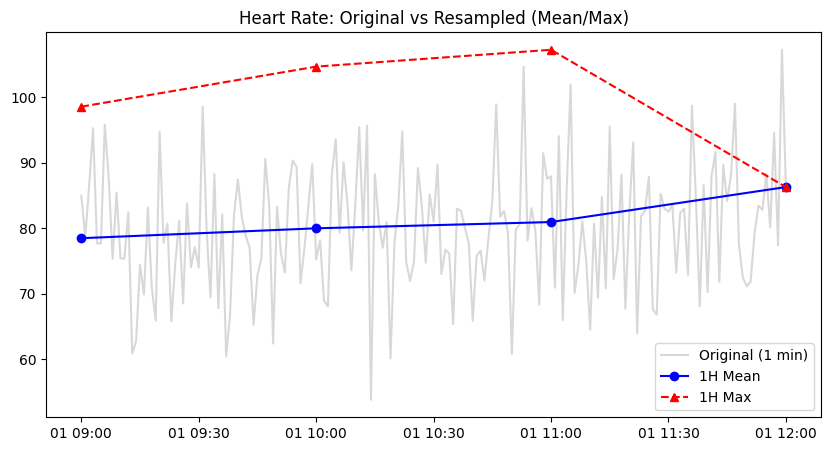

In [3]:

# 1시간(1H) 단위로 평균 심박수와 최대 심박수 동시 비교
hr_analysis = df['Heart_Rate'].resample('1H').agg(['mean', 'max', 'min'])

print("\n[심박수 정밀 분석] 1시간 단위:")
display(hr_analysis.round(1))

# 시각화 비교
plt.figure(figsize=(10, 5))
plt.plot(df.index, df['Heart_Rate'], label='Original (1 min)', alpha=0.3, color='gray') # 원본은 흐리게
plt.plot(hr_analysis.index, hr_analysis['mean'], label='1H Mean', marker='o', color='blue') # 평균은 파란색
plt.plot(hr_analysis.index, hr_analysis['max'], label='1H Max', marker='^', color='red', linestyle='--') # 최대값은 빨간색

plt.title("Heart Rate: Original vs Resampled (Mean/Max)")
plt.legend()
plt.show()

# 해석: 회색 선(원본)은 매우 시끄럽지만(Noisy), 파란 선(평균)은 추세를 보여준다.
# 빨간 점선(최대값)은 해당 시간대에 발생한 이벤트(Event)를 놓치지 않게 해준다.



### 4. 업 샘플링 (Up-sampling): 빈 곳 채우기
이번에는 반대로 드문드문 있는 데이터를 촘촘하게 늘려본다.
예: 1시간마다 측정된 체온 데이터를 10분 단위로 늘린다.


[원본] 드문 데이터 (1시간 간격):


/tmp/ipython-input-1856976747.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  sparse_index = pd.date_range('2025-01-01 09:00', '2025-01-01 12:00', freq='1H')


,Temp
2025-01-01 09:00:00,36.5
2025-01-01 10:00:00,36.6
2025-01-01 11:00:00,37.0
2025-01-01 12:00:00,36.8



[업 샘플링 직후] 결측치 발생:


/tmp/ipython-input-1856976747.py:10: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_up = df_sparse.resample('10T').asfreq()


,Temp
2025-01-01 09:00:00,36.5
2025-01-01 09:10:00,NaN
2025-01-01 09:20:00,NaN
2025-01-01 09:30:00,NaN
2025-01-01 09:40:00,NaN
2025-01-01 09:50:00,NaN
2025-01-01 10:00:00,36.6



[Forward Fill 적용] 빈 곳 채우기:


/tmp/ipython-input-1856976747.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_ffill = df_sparse.resample('10T').ffill()


,Temp
2025-01-01 09:00:00,36.5
2025-01-01 09:10:00,36.5
2025-01-01 09:20:00,36.5
2025-01-01 09:30:00,36.5
2025-01-01 09:40:00,36.5
2025-01-01 09:50:00,36.5
2025-01-01 10:00:00,36.6


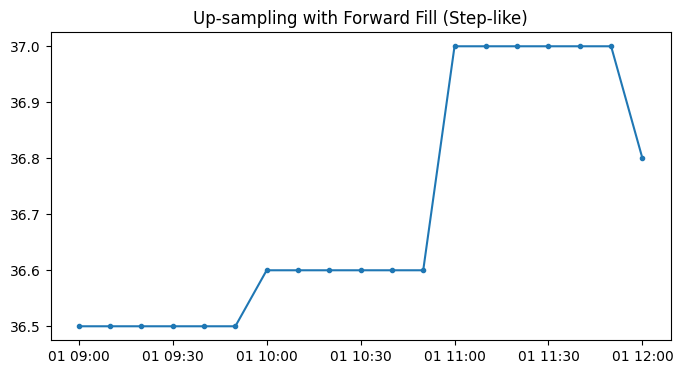

In [4]:

# 1시간 간격의 데이터 생성
sparse_index = pd.date_range('2025-01-01 09:00', '2025-01-01 12:00', freq='1H')
df_sparse = pd.DataFrame({'Temp': [36.5, 36.6, 37.0, 36.8]}, index=sparse_index)

print("\n[원본] 드문 데이터 (1시간 간격):")
display(df_sparse)

# 10분(10T) 간격으로 늘리기
# 단순히 resample만 하면 데이터가 없어서 NaN(결측치)이 생긴다.
df_up = df_sparse.resample('10T').asfreq()

print("\n[업 샘플링 직후] 결측치 발생:")
display(df_up.head(7))

# Forward Fill (ffill) 적용
# "직전에 측정한 체온이 다음 측정 때까지 유지된다"고 가정하는 방식이다.
df_ffill = df_sparse.resample('10T').ffill()

print("\n[Forward Fill 적용] 빈 곳 채우기:")
display(df_ffill.head(7))

# 시각화로 채워진 형태 확인 (계단식 모양)
plt.figure(figsize=(8, 4))
plt.plot(df_ffill.index, df_ffill['Temp'], marker='.', linestyle='-')
plt.title("Up-sampling with Forward Fill (Step-like)")
plt.show()


### 📝 실습 과제
위에서 생성한 `df`(1분 간격 심박수/걸음 수) 데이터를 이용하여 다음을 수행한다.
1.  데이터를 15분(`15T`) 간격으로 리샘플링한다.
2.  이때 심박수(`Heart_Rate`)의 표준편차(`std`)를 구한다. (표준편차가 크다는 것은 심박수가 불안정하다는 뜻이다.)

15분 간격 심박 변동성(표준편차):


/tmp/ipython-input-1784275459.py:4: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_std = df['Heart_Rate'].resample('15T').std()


,Heart_Rate
2025-01-01 09:00:00,9.941558
2025-01-01 09:15:00,7.778856
2025-01-01 09:30:00,10.183034
2025-01-01 09:45:00,8.425265
2025-01-01 10:00:00,11.575077


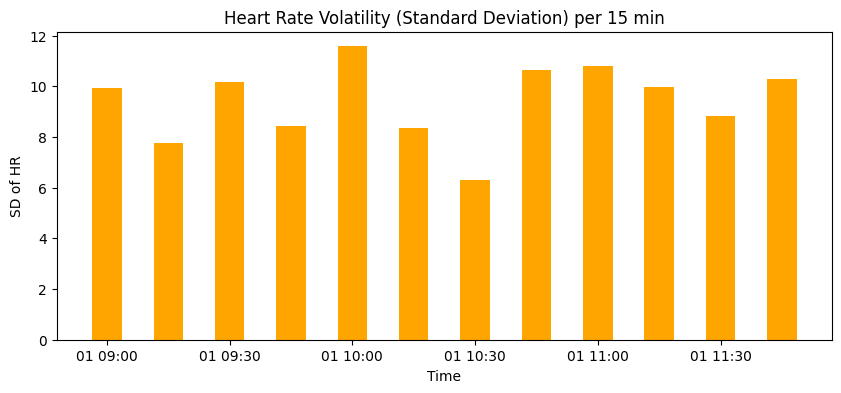

In [5]:
# [실습 답안 예시]

# 15분 간격 표준편차 계산
df_std = df['Heart_Rate'].resample('15T').std()

print("15분 간격 심박 변동성(표준편차):")
display(df_std.head())

# 시각화
plt.figure(figsize=(10, 4))
plt.bar(df_std.index, df_std.values, width=0.005, color='orange') # width는 시간축에 따라 조절 필요
plt.title("Heart Rate Volatility (Standard Deviation) per 15 min")
plt.xlabel("Time")
plt.ylabel("SD of HR")
plt.show()
